In [18]:
!pip install torchxrayvision

In [19]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import cv2
import torchvision
from torchvision import transforms
from PIL import Image
import torch
import os
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import json 
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch import nn
import torchtext
# from tqdm import tqdm
from tqdm.notebook import tqdm
import timm
from torch.optim.lr_scheduler import *
from sklearn.model_selection import KFold #k fold交叉验证
import torchxrayvision as xrv
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from statistics import mean
# from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class imageDataset(Dataset):
    def __init__(self, path):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        
        self.train_files = []
        
        for root, dirs, files in walk(path):
          for f in files:
            fullpath = join(root, f)
            if fullpath.endswith('jpeg'):
                self.train_files.append(fullpath)
        self.transforms = [
            torchvision.transforms.Resize([224, 224]),
            torchvision.transforms.RandomHorizontalFlip(0.5),
            torchvision.transforms.RandomRotation(degrees=(-5, 5)), 
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225])
            ]
        
        # 22 个 transform 的方法
        #https://blog.csdn.net/u011995719/article/details/85107009
            
    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        file = self.train_files[index]
        img = Image.open(file).convert('RGB')
        img = torchvision.transforms.Compose(self.transforms)(img)
        #label = file.split('/')[-1].split('_')[0]
        label = file.split('/')[-2]
        if label == 'NORMAL': label = 0
        else: label = 1
        
        return img, label
    
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len( self.train_files)

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


In [47]:
class MyTrainer:
    def __init__(self,
                 
                 net,
                 optm,
                 criterion,
                 train_dataset,
                 val_dataset,
                 batch_size,
                 scheduler,
                 l1_lambda=.0,
                 l2_lambda=.0,
                 debug = 0
                 ):
        
        self.optm = optm
        self.net = net
        self.criterion = criterion
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        
        self.scheduler = scheduler
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.best_val_acc = .0
        self.debug = debug
        self.get_dataloader()
        self.train_losses = []
        self.eval_losses = []
        self.train_accs = []
        self.val_accs = []
        self.train_f1s = []
        self.val_f1s = []
        
    def get_dataloader(self, shuffle=True, num_workers=0):
        batch_size = self.batch_size
        train_dl = DataLoader(self.train_dataset,batch_size=batch_size, shuffle=True, num_workers=0)
        val_dl = DataLoader(self.val_dataset,batch_size=batch_size, shuffle=True, num_workers=0)
        self.train_dl = train_dl
        self.val_dl = val_dl
    
    def train_batch(self):
        self.net.train()
        y_hats = []
        ys = []
        batch_train_loss = []
        for x, y in tqdm(self.train_dl):
            #print(x, y)
            x = x.to(device)
            y = y.to(device) #[batch, 1] #[0, 1, 2, 3, 4 ...]
            y_hat=self.net(x) #[batch, num_class] [0.1, 0.1, 0.1, 0.9 ...] [0]
            y_hats.append(y_hat)
            ys.append(y)
            loss=self.criterion(y_hat.squeeze(1), y) # 计算损失 
            
            #l1 reg
            l1_norm = sum(p.pow(1.0).sum() for p in self.net.parameters())    
            loss = loss + self.l1_lambda * l1_norm
            
            #l2 reg
            l2_norm = sum(p.pow(2.0).sum() for p in self.net.parameters()) #模型参数的复杂度  
            loss = loss + self.l2_lambda * l2_norm
            
            self.optm.zero_grad() # 前一步的损失清零
            loss.backward() # 反向传播
            self.optm.step() # 优化
            batch_train_loss.append(loss.item())
            if self.debug:
                break
            
        y_hats = torch.cat(y_hats, dim=0)
        ys = torch.cat(ys, dim=0)
        #print(y_hats.shape, ys.shape)
        train_acc = self.test_acc(y_hats.squeeze(1), ys)
        batch_train_loss = mean(batch_train_loss)
        train_f1 = self.test_f1(y_hats, ys)
        return batch_train_loss, train_acc, train_f1
            
    def val_batch(self):
        self.net.eval()
        y_hats = []
        ys = []
        batch_val_loss = []
        with torch.no_grad():
            for x, y in tqdm(self.val_dl):
                x = x.to(device)
                y = y.to(device)
                y_hat=self.net(x)
                y_hats.append(y_hat)
                ys.append(y)
                loss=self.criterion(y_hat.squeeze(1), y) # 计算损失
                batch_val_loss.append(loss.item())
                if self.debug:
                    break
        y_hats = torch.cat(y_hats, dim=0)
        ys = torch.cat(ys, dim=0)
        val_acc = self.test_acc(y_hats.squeeze(1), ys)
        batch_val_loss = mean(batch_val_loss)
        val_f1 = self.test_f1(y_hats, ys)
        return batch_val_loss, val_acc, val_f1
            
    
    def test_acc(self, pred, lab):
        t=pred.max(-1)[1]==lab
        return torch.mean(t.float()).item()
    
    def test_f1(self, pred, lab):
        pred=pred.max(-1)[1]
        f1 = f1_score(lab.cpu().detach(), pred.cpu().detach())
        return f1

    def train_epoch(self, epochs, model_path='model.pt'):
        self.train_losses, self.val_losses, self.train_accs, self.val_accs, self.train_f1s, self.val_f1s = [], [], [], [], [], []
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc, train_f1 = self.train_batch()
            val_loss, val_acc, val_f1 = self.val_batch()
#             train_loss = round(sum(batch_train_loss)/len(batch_train_loss),4)
#             train_acc = round((sum(batch_train_acc)/len(batch_train_acc)).item(), 4)
#             val_loss = round(sum(batch_val_loss)/len(batch_val_acc),4)
#             val_acc = round((sum(batch_val_acc)/len(batch_val_acc)).item(), 4)
            print('epoch:', epoch, 'train_loss', train_loss, 'train_acc', train_acc, 'val_loss', val_loss, 'val_acc', val_acc)
            print(train_f1, val_f1)
            self.scheduler.step()
            if val_acc >= self.best_val_acc:
                torch.save(self.net.state_dict(), model_path)
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.train_f1s.append(train_f1)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)
            self.val_f1s.append(val_f1)
            np.save( 'train_losses', np.array(self.train_losses))
            np.save('train_accs', np.array(self.train_accs))
            np.save('train_f1s', np.array(self.train_f1s))
            np.save('val_losses', np.array(self.val_losses))
            np.save('val_accs', np.array(self.val_accs))
            np.save('val_f1s', np.array(self.val_f1s))
            if self.debug:
                break
        
    def train_k_fold(self, k, epoch):
        batch_size = self.batch_size
        dataset = self.dataset
        kf = KFold(n_splits=k)
        for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(dataset)))):
            print('fold', fold)
            train_ds = Subset(dataset, train_idx)
            val_ds = Subset(dataset, val_idx)
            self.train_dl = DataLoader(train_ds,batch_size=batch_size, shuffle=True, num_workers=0)
            self.val_dl = DataLoader(val_ds,batch_size=batch_size, shuffle=True, num_workers=0)
            self.train_epoch(epoch, 'model_fold_'+str(fold)+'.pt')
    
    def pred(self, test_ds, model_path='model.pt'):
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        self.net.load_state_dict(torch.load(model_path))
        y_hats = []
        ys = []
        with torch.no_grad():
            for x, y in tqdm(test_dl):
                x = x.to(device)
                y = y.to(device)
                y_hat=self.net(x)
                y_hats.append(y_hat)
                ys.append(y)
        y_hats = torch.cat(y_hats, dim=0)
        ys = torch.cat(ys, dim=0)
        return y_hats, ys
    
    def pred_k_fold(self, test_ds, k):
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        mean_y_hats = []
        for fold in range(k):
            self.net.load_state_dict( torch.load('model_fold_'+str(fold)+'.pt') )
            y_hats = []
            for x, y in tqdm(test_dl):
                x = x.to(device)
                y = y.to(device)
                y_hat=net(x)
                y_hats.append(y_hat)
                if self.debug:
                    break
            y_hats = torch.cat(y_hats, dim=0)
            mean_y_hats.append(y_hats)
        mean_y_hats = torch.stack(mean_y_hats, dim=0)
        mean_y_hats = torch.mean(mean_y_hats, dim=0)
        return mean_y_hats
    

In [21]:
dataset = imageDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train/')
img, label = dataset.__getitem__(0)
img.shape

torch.Size([3, 224, 224])

In [48]:
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
val_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
train_dataset = imageDataset(train_path)
val_dataset = imageDataset(val_path)
# net = xrv.models.DenseNet(num_classes=2, in_channels=1, 
#                                 **xrv.models.get_densenet_params('densenet121-res224-chex')).to(device)
net = timm.create_model('densenet121', pretrained=True, num_classes = 2).to(device)
criterion=nn.CrossEntropyLoss() # 使用CrossEntropyLoss损失
optm=torch.optim.Adam(net.parameters()) # Adam优化
batch_size = 64
epochs = 10
# scheduler = CosineAnnealingLR(optm, T_max=epochs)
scheduler = ExponentialLR(optm, gamma=0.9)
trainer = MyTrainer(net, optm, criterion, train_dataset, val_dataset, batch_size, scheduler, debug=0)

In [23]:
trainer.train_epoch(epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 train_loss 0.10893475910557843 train_acc 0.959930956363678 val_loss 0.7299220323562622 val_acc 0.7676281929016113
0.9730635391158655 0.8422198041349293


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 train_loss 0.05343580368065798 train_acc 0.9769938588142395 val_loss 0.892655149102211 val_acc 0.75
0.9845400669930431 0.8329764453961456


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 2 train_loss 0.04069433091549066 train_acc 0.985237717628479 val_loss 0.5789549499750137 val_acc 0.8541666865348816
0.9900657979615534 0.8950403690888119


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 3 train_loss 0.030433239601978395 train_acc 0.9884968996047974 val_loss 0.5440494775772095 val_acc 0.8557692170143127
0.9922640536358946 0.8955916473317866


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 4 train_loss 0.027421439464754855 train_acc 0.9909892678260803 val_loss 1.1356904923915863 val_acc 0.7756410241127014
0.9939378305172192 0.8474945533769063


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 5 train_loss 0.027780077699855788 train_acc 0.991180956363678 val_loss 1.2279145896434784 val_acc 0.7772436141967773
0.9940629839958699 0.8487486398258978


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 6 train_loss 0.019056508210757408 train_acc 0.9930981397628784 val_loss 0.7927628099918366 val_acc 0.8269230723381042
0.9953572349754964 0.8783783783783784


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 7 train_loss 0.012180698559926142 train_acc 0.9952070116996765 val_loss 1.0399685382843018 val_acc 0.8157051205635071
0.9967729443655609 0.8715083798882681


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 8 train_loss 0.007014852064546686 train_acc 0.9980828166007996 val_loss 1.328987044095993 val_acc 0.7932692170143127
0.9987093443469283 0.8577728776185226


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 9 train_loss 0.007529702933846615 train_acc 0.997124195098877 val_loss 1.0143098711967469 val_acc 0.8333333730697632
0.9980657640232109 0.8820861678004536


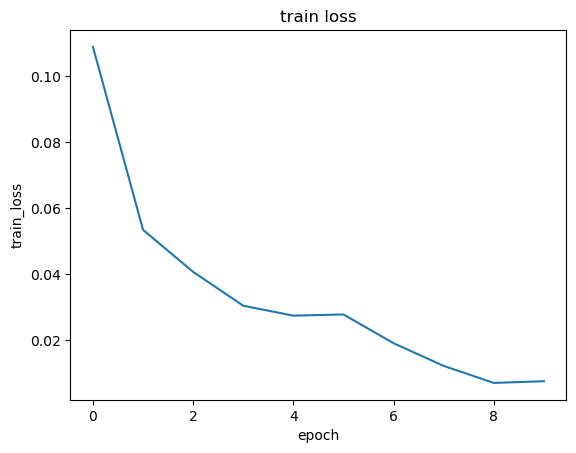

In [31]:
import matplotlib.pyplot as plt
y = trainer.train_losses
x = range(epochs)
plt.plot(x, y)
plt.title("train loss") # title
plt.ylabel("train_loss") # y label
plt.xlabel("epoch") # x label
plt.savefig('train_loss.png')

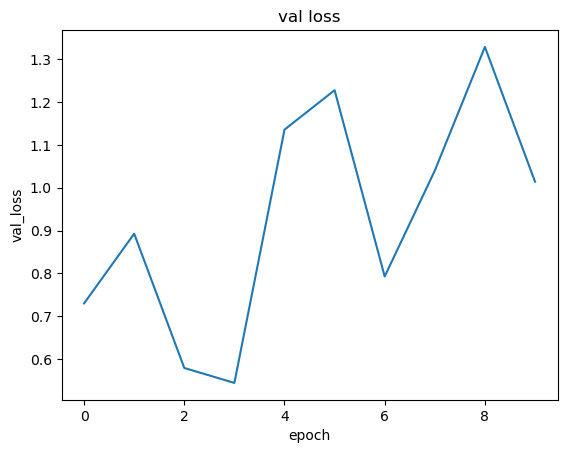

In [32]:
y = trainer.val_losses
plt.plot(x, y)
plt.title("val loss") # title
plt.ylabel("val_loss") # y label
plt.xlabel("epoch") # x label
plt.savefig('val_loss.png')

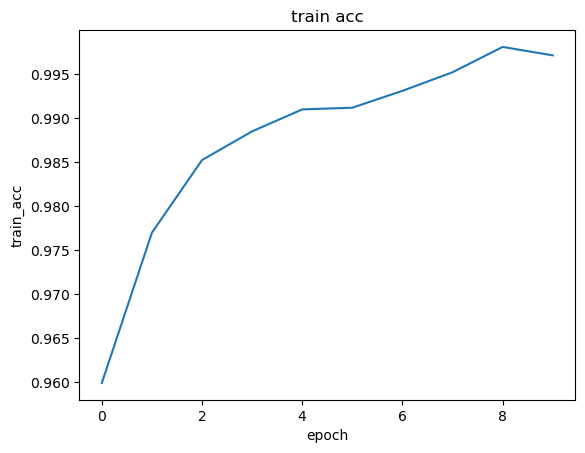

In [33]:
y = trainer.train_accs
plt.plot(x, y)
plt.title("train acc") # title
plt.ylabel("train_acc") # y label
plt.xlabel("epoch") # x label
plt.savefig('train_acc.png')

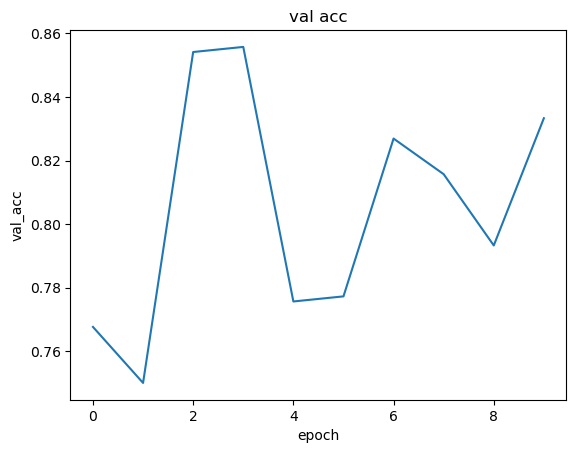

In [34]:
y = trainer.val_accs
plt.plot(x, y)
plt.title("val acc") # title
plt.ylabel("val_acc") # y label
plt.xlabel("epoch") # x label
plt.savefig('val_acc.png')

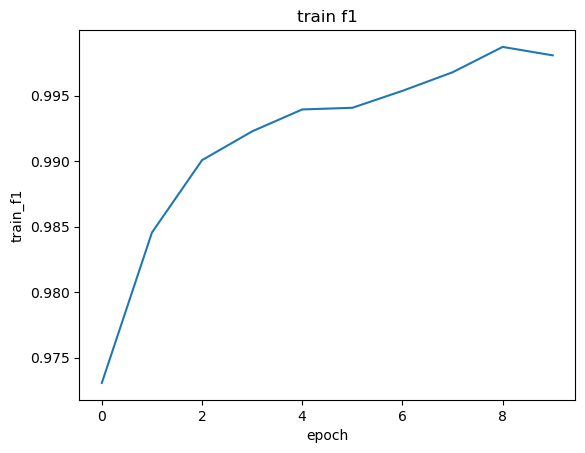

In [36]:
y = trainer.train_f1s
plt.plot(x, y)
plt.title("train f1") # title
plt.ylabel("train_f1") # y label
plt.xlabel("epoch") # x label
plt.savefig('train_f1.png')

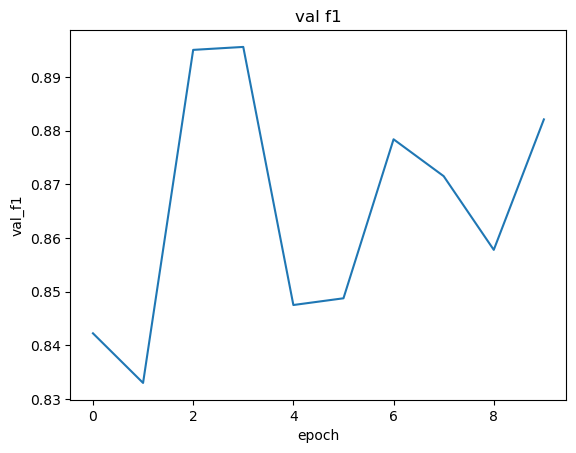

In [37]:
y = trainer.val_f1s
plt.plot(x, y)
plt.title("val f1") # title
plt.ylabel("val_f1") # y label
plt.xlabel("epoch") # x label
plt.savefig('val_f1.png')

In [62]:
pred, lab = trainer.pred(val_dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

In [76]:
pr = pred.max(-1)[1].cpu().detach()
lab = lab.cpu().detach()
t = pr==lab
acc = torch.mean(t.float()).item()
f1 = f1_score(pr, lab) 
print('acc', acc, 'f1',f1)

acc 0.8862179517745972 f1 0.9161747343565525


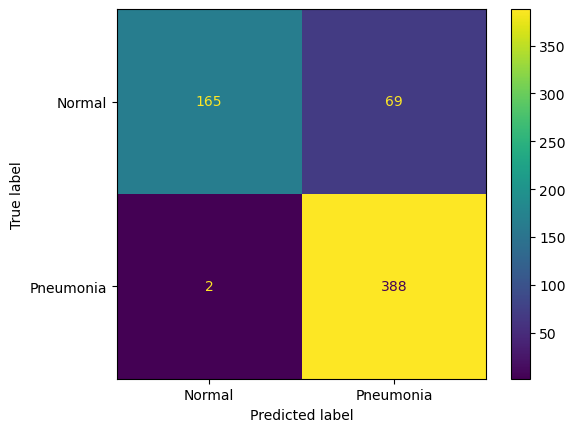

<Figure size 640x480 with 0 Axes>

In [77]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(lab, pr)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Normal', 'Pneumonia'])

cm_display.plot()
plt.show()
plt.savefig('confusion-matrix.jpg')